<a href="https://colab.research.google.com/github/Photonsinnovate/flower-classifier-/blob/main/Oxford_flower_classification_using_fastai_95_4_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install fastai - a pytorch-based deep learning library

In [ ]:
!pip install -Uqq fastai

The vision module will be required for this task

In [ ]:
from fastai.vision.all import *

untar_data is a fastai function that downloads the images from the source website

In [ ]:
path = untar_data(URLs.FLOWERS)

In [ ]:
f_train = path/'train.txt'
f_valid = path/'valid.txt'
f_test = path/'test.txt'

In [ ]:
f_train,f_valid,f_test

(Path('/root/.fastai/data/oxford-102-flowers/train.txt'),
 Path('/root/.fastai/data/oxford-102-flowers/valid.txt'),
 Path('/root/.fastai/data/oxford-102-flowers/test.txt'))

The dataset was originally divided into three - train, valid and test. However, I used the train and vaild data for training and the test data for validation. This offers more images for training, thereby making the model more robust.

In [ ]:
train_df = pd.read_csv(f_train, delimiter='\n', names=['flower'])
valid_df = pd.read_csv(f_valid, delimiter='\n', names=['flower'])
train_df = pd.concat([train_df, valid_df], ignore_index=True)
train_list = train_df.values.tolist()
test_df = pd.read_csv(f_test, delimiter='\n', names=['flower'])
test_list = test_df.values.tolist()

Using regular expression to extract the labels and paths required by the datablock API

In [ ]:
l_train = [(re.findall('\d', str(f))) for f in train_list]
l_test = [(re.findall('\d', str(f))) for f in test_list]

The code below separates the image path from the labels

In [ ]:
train_path = [''.join(i[:5]) for i in l_train]
train_labels = [''.join(i[5:]) for i in l_train]
test_path = [''.join(i[:5]) for i in l_test]
test_labels = [''.join(i[5:]) for i in l_test]

creating the train and test dataframe. I also a new column 'is_valid', this will distinquish between the train and valid data

In [ ]:
d_train = {'path': train_path, 'labels': train_labels}
d_test = {'path': test_path, 'labels': test_labels}
tr_df = pd.DataFrame(d_train)
tr_df['is_valid'] = False
te_df = pd.DataFrame(d_test)
te_df['is_valid'] = True
df = pd.concat([tr_df, te_df], ignore_index=True)

checking for null values after concatenting the train and test dataframes

In [ ]:
df['labels'].isnull().sum()

0

Below are the 102 labels required for this task

In [ ]:
labels = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
len(labels)

102

I converted the label list to a dictionary for ease of mapping with the dataframe

In [ ]:
t_labels = pd.DataFrame(labels, columns=['flowers'])
labels_dict = t_labels.to_dict()['flowers']

In [ ]:
_df = df.copy()
_df['label'] = _df.labels.astype(int).map(labels_dict)
_df['images'] = _df.path.map(lambda x : path/f'jpg/image_{x}.jpg')
_df = _df.drop(columns=['path','labels'])

In [ ]:
_df.head(2)

,is_valid,label,images
0,False,purple coneflower,/root/.fastai/data/oxford-102-flowers/jpg/image_03860.jpg
1,False,spear thistle,/root/.fastai/data/oxford-102-flowers/jpg/image_06092.jpg


The datablock API where we create our dataset and dataloader

In [ ]:
dls = DataBlock(blocks= (ImageBlock, CategoryBlock),
                get_x = ColReader(2),
                get_y = ColReader(1),
                splitter = ColSplitter('is_valid'),
                item_tfms = Resize(225),
                batch_tfms = aug_transforms()).dataloaders(_df, bs=32)

Display samples from the dataset, to have a sense of what the images look like.

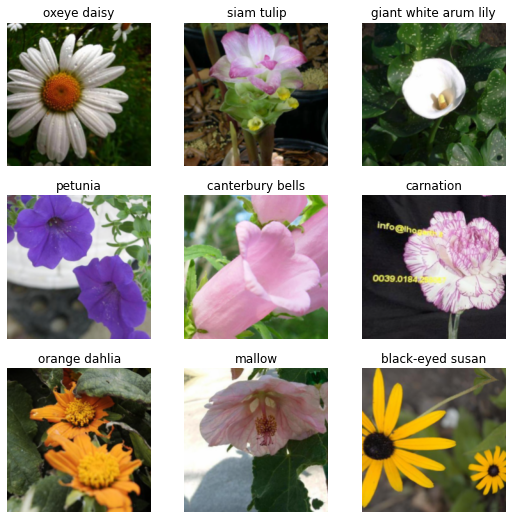

In [ ]:
dls.show_batch()

The cnn_learner houses the dataloader, the model, metrics and callbacks. After doing a little experimentation with other models, I discovered that desnsenet201 offered the best accuracy 

In [ ]:
learn = cnn_learner(dls, densenet201, metrics=accuracy, cbs=ShowGraphCallback())

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


learn.lr_find() is used for finding the best learning rate for the model

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.009120108559727669)

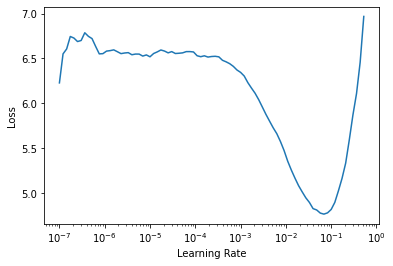

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,3.531499,1.079746,0.759961,01:21


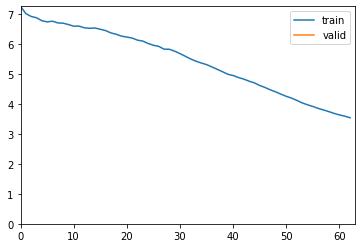

epoch,train_loss,valid_loss,accuracy,time
0,0.762779,0.520943,0.882420,01:25
1,0.421983,0.367933,0.910717,01:23
2,0.278671,0.271607,0.930558,01:25
3,0.167967,0.225581,0.939665,01:23
4,0.091178,0.221813,0.942430,01:25
5,0.051823,0.185463,0.951537,01:26
6,0.032788,0.180627,0.951862,01:23
7,0.024670,0.171733,0.956904,01:25
8,0.021428,0.177429,0.954952,01:23


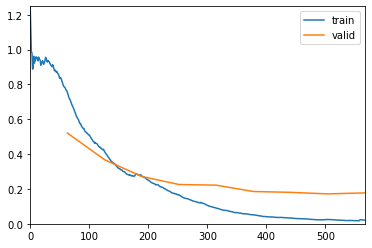

In [ ]:
learn.fine_tune(9)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

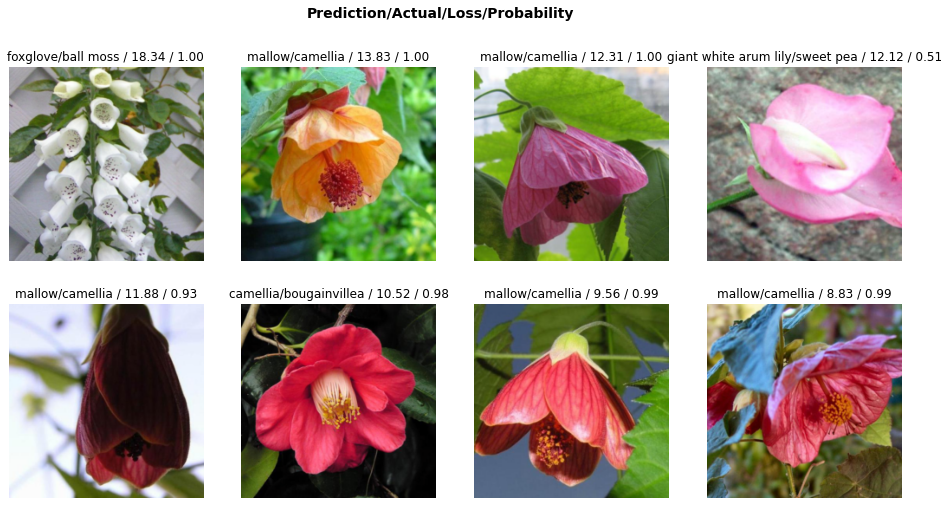

In [ ]:
interp.plot_top_losses(8, nrows=2, figsize=(16,8))

In [ ]:
learn.export()

In [ ]:
learn_inf = load_learner('./export.pkl')

In [ ]:
learn_inf.dls.vocab

['alpine sea holly', 'anthurium', 'artichoke', 'azalea', 'ball moss', 'balloon flower', 'barbeton daisy', 'bearded iris', 'bee balm', 'bird of paradise', 'bishop of llandaff', 'black-eyed susan', 'blackberry lily', 'blanket flower', 'bolero deep blue', 'bougainvillea', 'bromelia', 'buttercup', 'californian poppy', 'camellia', 'canna lily', 'canterbury bells', 'cape flower', 'carnation', 'cautleya spicata', 'clematis', "colt's foot", 'columbine', 'common dandelion', 'corn poppy', 'cyclamen ', 'daffodil', 'desert-rose', 'english marigold', 'fire lily', 'foxglove', 'frangipani', 'fritillary', 'garden phlox', 'gaura', 'gazania', 'geranium', 'giant white arum lily', 'globe thistle', 'globe-flower', 'grape hyacinth', 'great masterwort', 'hard-leaved pocket orchid', 'hibiscus', 'hippeastrum ', 'japanese anemone', 'king protea', 'lenten rose', 'lotus', 'love in the mist', 'magnolia', 'mallow', 'marigold', 'mexican aster', 'mexican petunia', 'monkshood', 'moon orchid', 'morning glory', 'orange 

I downloaded a flower from the internet to test my model and the model predicted correctly.

In [ ]:
learn_inf.predict('../input/rubylipped/ruby-lipped-cattleya.jpg')

('ruby-lipped cattleya',
 tensor(79),
 tensor([2.7136e-06, 2.8558e-07, 2.5690e-05, 4.9543e-06, 7.0577e-06, 9.0872e-06,
         1.5456e-06, 7.5896e-04, 2.3083e-06, 8.8522e-06, 2.0661e-07, 1.0677e-06,
         1.6011e-06, 1.2480e-05, 2.5773e-05, 2.0423e-05, 7.4432e-07, 1.7890e-07,
         8.5678e-06, 3.4537e-06, 3.6862e-05, 6.0763e-06, 6.6953e-06, 3.8116e-06,
         1.6447e-06, 3.8396e-04, 3.7710e-07, 2.0974e-06, 6.0373e-06, 4.8308e-07,
         1.8211e-06, 2.8823e-04, 3.0499e-06, 2.1966e-05, 1.4755e-07, 4.0779e-06,
         1.3719e-05, 2.4815e-06, 9.0460e-09, 9.6904e-06, 5.2404e-06, 1.0636e-07,
         4.7201e-06, 2.8659e-06, 7.7325e-08, 1.8733e-07, 1.0317e-06, 1.4858e-07,
         1.9624e-07, 2.0667e-04, 3.2968e-06, 6.9340e-06, 9.0958e-06, 2.2933e-07,
         3.1766e-06, 1.3466e-07, 3.3490e-06, 1.1041e-06, 1.5093e-06, 2.0220e-05,
         1.5457e-06, 8.4585e-06, 6.5469e-06, 5.8337e-06, 4.5762e-07, 1.1386e-06,
         4.8735e-04, 2.3577e-05, 1.1537e-06, 6.5560e-08, 3.8109e-06, 3.